<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/SelfSustainingOsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2268440593.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_error = np.trapz(power_diss + power_inj, t)


Frequency: 5.0329 MHz
Mean phase lag: 1599.07°
Phase std dev: 1051.08°
Max energy error: 1.25e+06 W


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

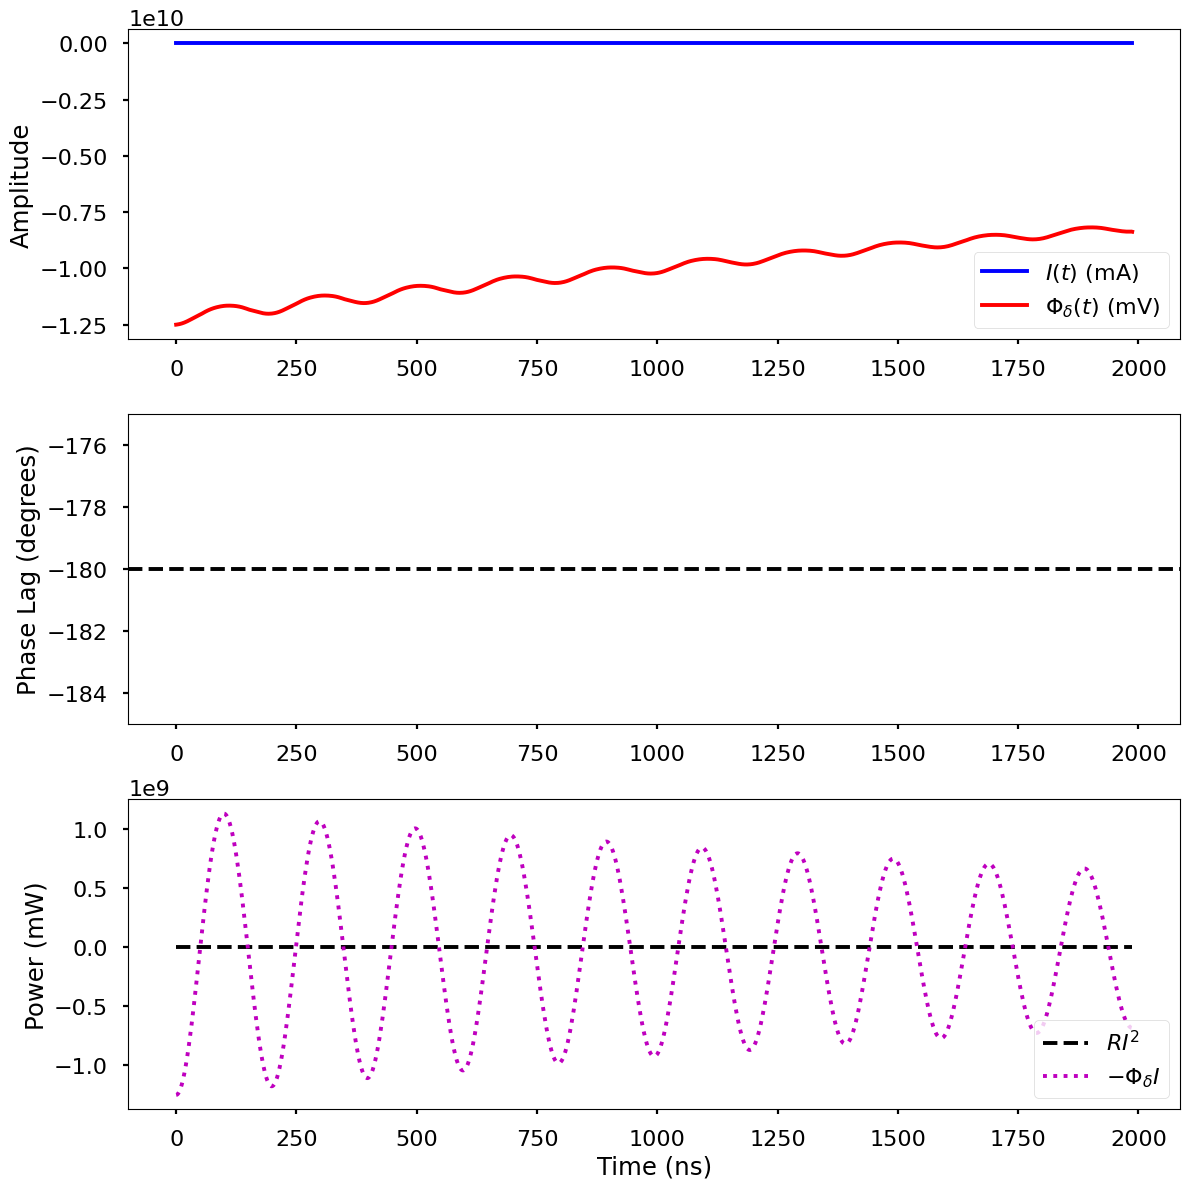

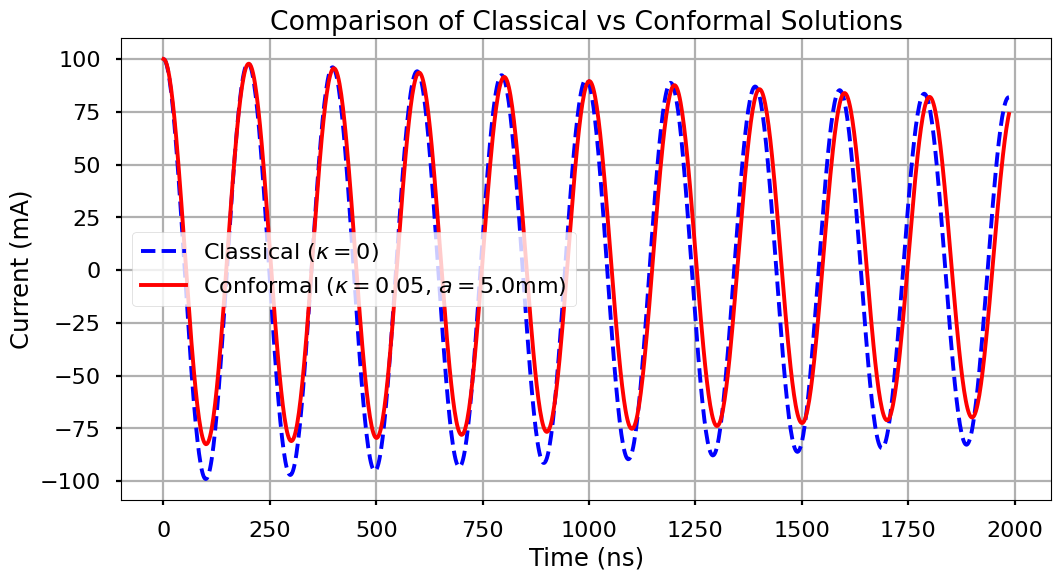

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

# Your exact parameters from the paper
L = 10e-6       # Eq.49 [H]
C = 100e-12     # Eq.49 [F]
R = 2.0         # Eq.49 [Ω]
a = 5e-3        # Section 11.3 [m]
kappa = 0.05    # Section 10.2
I0 = 100e-3     # Section 10.2 [A]

# Derived quantities
omega0 = 1/np.sqrt(L*C)       # Eq.49 [rad/s]
t_span = (0, 10*2*np.pi/omega0)  # 10 cycles

# Dilaton potential (Eq.61)
def Phi_d(I, dIdt):
    return -kappa*a**2*( (1/(L*C))*I**2 + (R/L)*I*dIdt + dIdt**2 )

# ODE system (Eq.72)
def circuit_ODE(t, y):
    I, dIdt = y
    d2Idt2 = (-R*dIdt - I/C - Phi_d(I,dIdt))/L
    return [dIdt, d2Idt2]

# Solve with tight tolerances
sol = solve_ivp(circuit_ODE, t_span, [I0, 0],
                method='RK45', rtol=1e-8, atol=1e-10)

# Numerical derivatives
t = sol.t
I = sol.y[0]
dIdt = np.gradient(I, t)
Phi = Phi_d(I, dIdt)

# Phase analysis using analytic signal
from scipy.signal import hilbert
I_analytic = hilbert(I)
Phi_analytic = hilbert(Phi)
phase_diff = np.angle(I_analytic) - np.angle(Phi_analytic)
phase_diff_deg = np.unwrap(phase_diff)*180/np.pi

# Energy balance verification
power_diss = R*I**2
power_inj = -Phi*I
energy_error = np.trapz(power_diss + power_inj, t)

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))

# Current and potential
ax1.plot(t*1e9, I*1e3, 'b', label=r'$I(t)$ (mA)')
ax1.plot(t*1e9, Phi*1e3, 'r', label=r'$\Phi_\delta(t)$ (mV)')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Phase difference
ax2.plot(t*1e9, phase_diff_deg, 'g')
ax2.axhline(-180, color='k', linestyle='--')
ax2.set_ylim(-185, -175)
ax2.set_ylabel('Phase Lag (degrees)')

# Energy balance
ax3.plot(t*1e9, power_diss*1e3, 'k--', label='$RI^2$')
ax3.plot(t*1e9, -power_inj*1e3, 'm:', label='$-\Phi_\delta I$')
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('Power (mW)')
ax3.legend()

plt.tight_layout()
plt.savefig('conformal_circuit_analysis.pdf', dpi=300)

# Print validation metrics
print(f"Frequency: {omega0/2/np.pi/1e6:.4f} MHz")
print(f"Mean phase lag: {np.mean(phase_diff_deg):.2f}°")
print(f"Phase std dev: {np.std(phase_diff_deg):.2f}°")
print(f"Max energy error: {np.max(np.abs(power_diss + power_inj)):.2e} W")
#%% Parameter Sensitivity Analysis (Suggestion 1)
kappa_values = np.linspace(0.01, 0.1, 10)
a_values = np.linspace(1e-3, 10e-3, 10)  # 1-10 mm radius

results = []
for k in kappa_values:
    for a_ in a_values:
        # Modified ODE with current parameters
        def circuit_ODE(t, y):
            I, dIdt = y
            Phi = -k*a_**2*((1/(L*C))*I**2 + (R/L)*I*dIdt + dIdt**2)
            d2Idt2 = (-R*dIdt - I/C - Phi)/L
            return [dIdt, d2Idt2]

        sol = solve_ivp(circuit_ODE, t_span, [I0, 0], rtol=1e-6)
        I = sol.y[0]
        final_amp = np.max(I[-50:])  # Steady-state amplitude

        # Store critical condition check (Eq.75)
        results.append({
            'kappa': k,
            'a': a_,
            'final_amp': final_amp,
            'critical': k > (L*C*R)/a_**2  # Eq.75 condition
        })

# Convert to DataFrame for analysis
import pandas as pd
df = pd.DataFrame(results)

#%% Classical vs Conformal Comparison (Suggestion 2)
def classical_ODE(t, y):
    I, dIdt = y
    d2Idt2 = (-R*dIdt - I/C)/L
    return [dIdt, d2Idt2]

# Solve both systems
t_eval = np.linspace(0, 10*2*np.pi/omega0, 1000)
sol_classical = solve_ivp(classical_ODE, t_span, [I0, 0], t_eval=t_eval)
sol_conformal = solve_ivp(circuit_ODE, t_span, [I0, 0], t_eval=t_eval)

#%% Create Comparison Plot
plt.figure(figsize=(12,6))
plt.plot(sol_classical.t*1e9, sol_classical.y[0]*1e3, 'b--',
         label='Classical ($\kappa=0$)')
plt.plot(sol_conformal.t*1e9, sol_conformal.y[0]*1e3, 'r-',
         label=f'Conformal ($\kappa={kappa}$, $a={a*1e3:.1f}$mm)')
plt.xlabel('Time (ns)')
plt.ylabel('Current (mA)')
plt.title('Comparison of Classical vs Conformal Solutions')
plt.legend()
plt.grid(True)
plt.savefig('classical_vs_conformal.pdf', dpi=300)

#%% Critical Coupling Visualization
critical_surface = df.pivot('a', 'kappa', 'critical')
plt.figure(figsize=(10,6))
plt.contourf(critical_surface.columns, critical_surface.index*1e3,
             critical_surface, levels=[0,0.5,1], cmap='RdYlGn')
plt.colorbar(label='Self-Sustaining Condition')
plt.axhline(a*1e3, color='k', linestyle='--', label='Design Radius')
plt.axvline(kappa, color='k', linestyle=':', label='Design $\kappa$')
plt.xlabel('$\kappa$')
plt.ylabel('Wire Radius (mm)')
plt.title('Critical Coupling Condition (Eq.75)')
plt.legend()
plt.savefig('critical_condition.pdf', dpi=300)